Epoch 0, Train Loss: 0.6932, Validation Loss: 0.6956
Epoch 100, Train Loss: 0.0594, Validation Loss: 0.0491
Epoch 200, Train Loss: 0.0185, Validation Loss: 0.0146
Epoch 300, Train Loss: 0.0102, Validation Loss: 0.0076
Epoch 400, Train Loss: 0.0069, Validation Loss: 0.0049
Epoch 500, Train Loss: 0.0052, Validation Loss: 0.0036
Epoch 600, Train Loss: 0.0041, Validation Loss: 0.0028
Epoch 700, Train Loss: 0.0034, Validation Loss: 0.0023
Epoch 800, Train Loss: 0.0029, Validation Loss: 0.0019
Epoch 900, Train Loss: 0.0025, Validation Loss: 0.0016

Training Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Validation Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Test Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


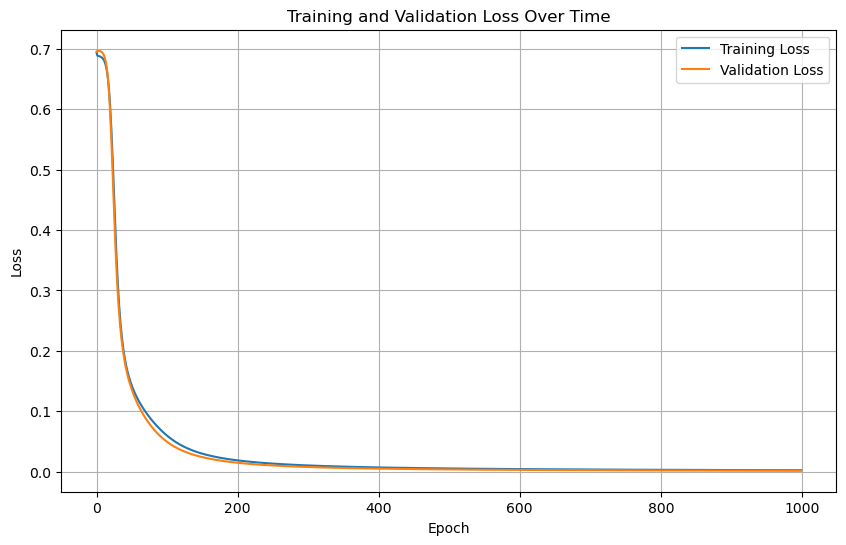

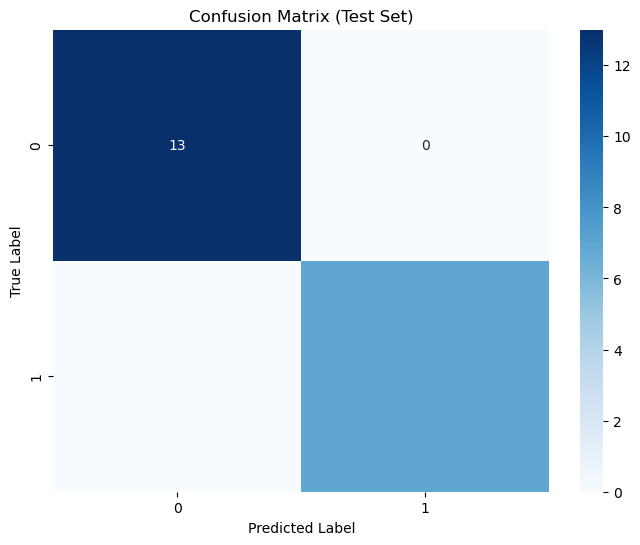

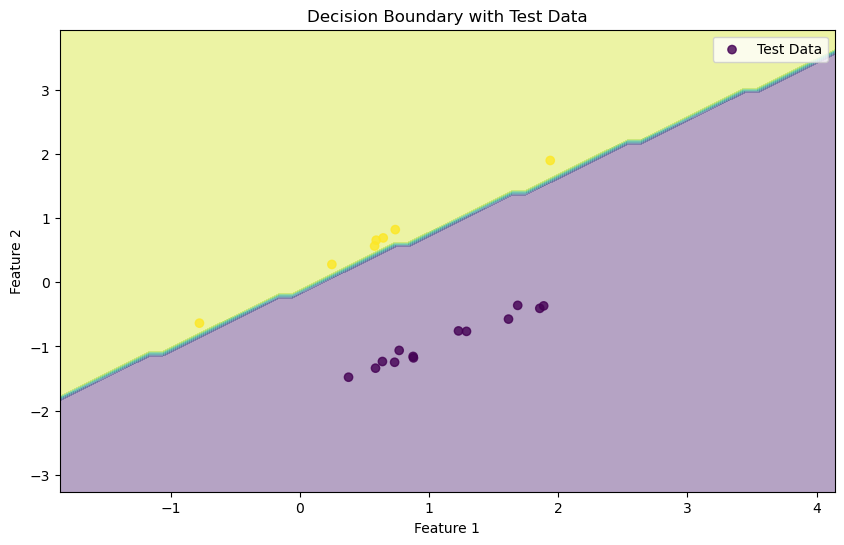

In [6]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class Layer:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        
    def forward(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.biases
        return self.output

class Activation:
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def sigmoid_derivative(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)

class NeuralNetwork:
    def __init__(self, n_features):
        self.hidden_layer = Layer(n_features, 4)
        self.output_layer = Layer(4, 1)
        self.activation = Activation()
        
    def forward(self, X):
        self.hidden_output = self.activation.sigmoid(self.hidden_layer.forward(X))
        self.output = self.activation.sigmoid(self.output_layer.forward(self.hidden_output))
        return self.output
    
    def compute_loss(self, y_true, y_pred):
        y_true = y_true.reshape(-1, 1)
        return np.mean(-y_true * np.log(y_pred + 1e-15) - (1 - y_true) * np.log(1 - y_pred + 1e-15))
    
    def backward(self, X, y, learning_rate=0.1):
        m = X.shape[0]
        y = y.reshape(-1, 1)
        
        output_error = self.output - y
        output_delta = output_error * self.activation.sigmoid_derivative(self.output)
        
        hidden_error = np.dot(output_delta, self.output_layer.weights.T)
        hidden_delta = hidden_error * self.activation.sigmoid_derivative(self.hidden_output)
        
        self.output_layer.weights -= learning_rate * np.dot(self.hidden_output.T, output_delta)
        self.output_layer.biases -= learning_rate * np.sum(output_delta, axis=0, keepdims=True)
        
        self.hidden_layer.weights -= learning_rate * np.dot(X.T, hidden_delta)
        self.hidden_layer.biases -= learning_rate * np.sum(hidden_delta, axis=0, keepdims=True)
    
    def train(self, X_train, y_train, X_val=None, y_val=None, epochs=1000):
        train_losses = []
        val_losses = []
        
        for epoch in range(epochs):
            # Forward pass and training loss
            train_output = self.forward(X_train)
            train_loss = self.compute_loss(y_train, train_output)
            train_losses.append(train_loss)
            
            # Backward pass (only on training data)
            self.backward(X_train, y_train)
            
            # Compute validation loss if validation data is provided
            if X_val is not None and y_val is not None:
                val_output = self.forward(X_val)
                val_loss = self.compute_loss(y_val, val_output)
                val_losses.append(val_loss)
            
            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}', end='')
                if X_val is not None:
                    print(f', Validation Loss: {val_loss:.4f}')
                else:
                    print()
        
        return train_losses, val_losses

    def predict(self, X, threshold=0.5):
        return (self.forward(X) >= threshold).astype(int)

# Generate dataset
X, y = make_classification(
    n_samples=100,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=1,
    random_state=42
)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Create and train the neural network
nn = NeuralNetwork(n_features=2)
train_losses, val_losses = nn.train(X_train, y_train, X_val, y_val, epochs=1000)

# Make predictions
y_train_pred = nn.predict(X_train)
y_val_pred = nn.predict(X_val)
y_test_pred = nn.predict(X_test)

# Calculate and print metrics
def print_metrics(y_true, y_pred, dataset_name):
    print(f"\n{dataset_name} Metrics:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")

print_metrics(y_train, y_train_pred, "Training")
print_metrics(y_val, y_val_pred, "Validation")
print_metrics(y_test, y_test_pred, "Test")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
if val_losses:
    plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot confusion matrix for test set
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot decision boundary
plt.figure(figsize=(10, 6))
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = nn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, alpha=0.8, label='Test Data')
plt.title('Decision Boundary with Test Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()